# All Spectrogram Code Setup

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                noverlap,
                                ord=None,
                                time_samp_prop=0.2,
                                filter_row_idx=None,                                
                                log_Sxx=False,
                                fs=1e3, window='hann', nperseg=128,
                                n_components=8, 
                                init='random', 
                                random_state=0, 
                                beta_loss='itakura-saito', 
                                solver = 'mu',
                                max_iter=400):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

# Addditional Utilities

- Extract the same trial across all channels

In [2]:
def get_same_trial_forall_channels(all_pat_chn_trials, trial_idx):
    """Get all trials for a single channel (for a specific patient, session and category)"""    
    same_trial_forall_channels = [channel_trials[trial_idx] for channel_trials in all_pat_chn_trials]
    same_trial_forall_channels = np.vstack(same_trial_forall_channels)
    return same_trial_forall_channels

# SPECIFICATION for DEMO: P41, Faces, Session 1

In [5]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = None # L2 norm

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

# Get all trials for by channel

In [7]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)
len(all_pat_chn_trials)

85

As expected there are 85 channels for P41 in session 1 for the Faces category

## Obtain trial 10 for all channels

In [9]:
pat_trial_10_all_chn = get_same_trial_forall_channels(all_pat_chn_trials = all_pat_chn_trials, trial_idx = spec_trial_idx)
#test_trial_1.shape
#test_trial_10[1, :]-all_pat_chn_trials[1][spec_trial_idx]
print(f"The dimension of all trials for channel {spec_trial_num} {pat_trial_10_all_chn.shape}")
print(f"The dimension of trials by time for channel {spec_trial_num} {all_pat_chn_trials[spec_trial_idx].shape}")

The dimension of all trials for channel 10 (85, 1500)
The dimension of trials by time for channel 10 (84, 1500)


#### Comments
- This makes sense, just 85 channels for P41 in session 1 for the Faces category
- This makes sense, just 84 **Face** trials in channel 1 for P41 in session 1.
- Let's extract the first trial only to test out the spectrogram fit.

### Fit the spectrogram

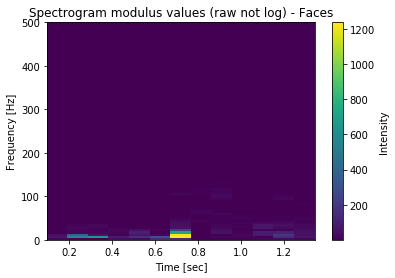

In [10]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[9][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=log_Sxx)

# Plot the spectrogram
plt.pcolormesh(t, f, Sxx)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

### Plot the **log** of the square modulus spectrogram values

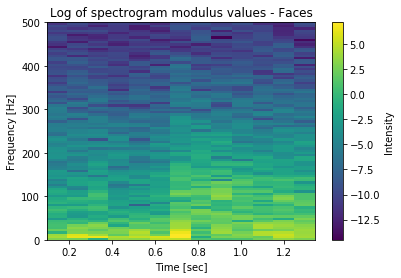

In [11]:
plt.pcolormesh(t, f, np.log(Sxx))
plt.title(f"Log of spectrogram modulus values - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

# Plot the Power Spectral Density for all Trials - Channel 10, P41, Faces, Session 1

In [12]:
def erp_gen_welch(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def psd_welch_trials(arr_all_trials, fs=1e3, window='hann', nperseg=128, noverlap=96,
                     trials_samp_idx=None, filter_row_idx=None):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_psds = [erp_gen_welch(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)[1] 
                      for idx in all_trial_idx]
        #print(trial_psds[0].shape)
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_psds = [erp_gen_welch(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)[1] 
                      for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_psd = np.vstack(trial_psds)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_psd = comb_psd
    else:
        comb_psd = comb_psd[filter_row_idx]
    return comb_psd

def plt_psd_welch_trials(comb_psd, freqs, title):
    comb_psd_T = comb_psd.T
    num_trials = comb_psd.shape[0]
    plt.figure(figsize=(15, 10))
    plt.semilogx(freqs, comb_psd_T[:,range(num_trials)])
    plt.title(title, fontsize=20)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()
    #plt.legend()

## First plot the PSD for a single trial - Channel 10, Trial 1

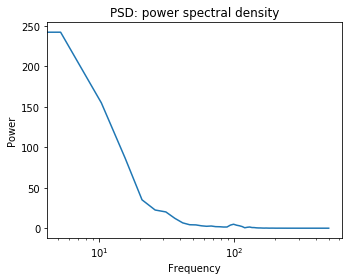

In [13]:
freqs, psd = signal.welch(x = all_pat_chn_trials[9][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

## Plot the Power Spectral Density for all Trials - Channel 10, P41, Faces, Session 1

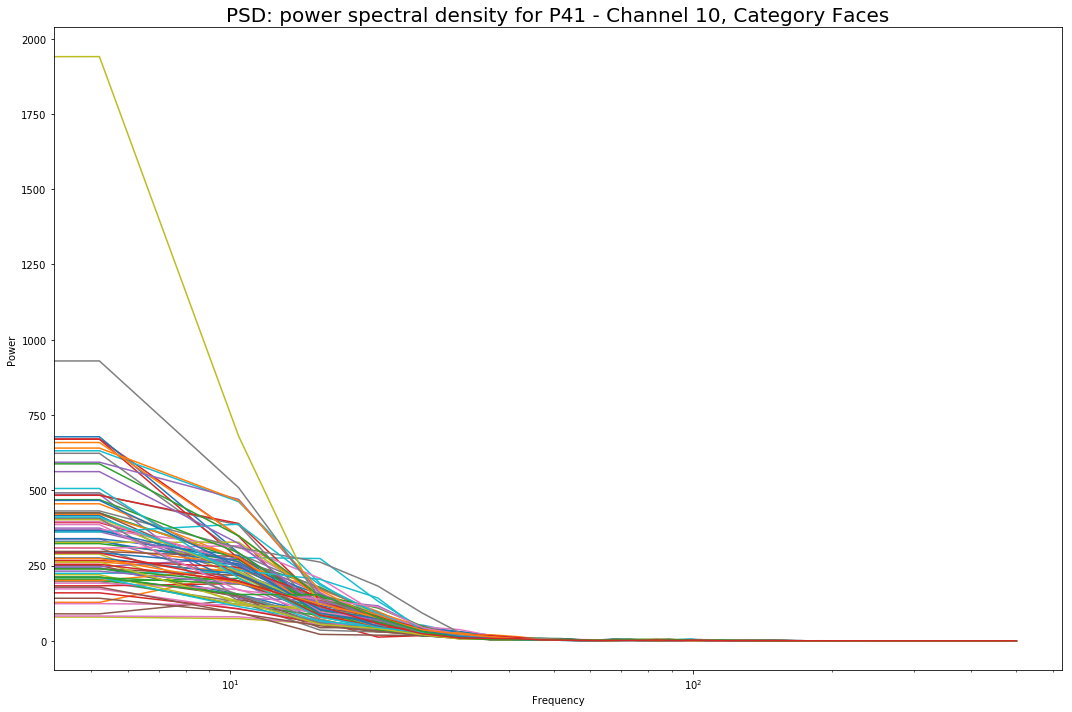

In [14]:
comb_psd = psd_welch_trials(arr_all_trials = all_pat_chn_trials[channel_idx], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, trials_samp_idx=None, filter_row_idx=None)
comb_psd_T = comb_psd.T
#print(f"The dimensions for the transposed PSDs for all P41, channel 10, Face trials is: {comb_psd_T.shape}")
plt_psd_welch_trials(comb_psd = comb_psd, freqs = freqs, title=f"PSD: power spectral density for P{patient_num} - Channel {channel_num}, Category {core_cat}")

As we can see, the welch spectrogram of all P41, Channel 10, Face trials appears to be observing a powerlaw property (on semi-log scale for the x-axis)

# Wavelet Graph comparison

- Take a single channel - all 83 trials
    - We will do the same for a single trial
- Get all spectrograms for all trials within a single channel (log scale)
    - we will repeat this for the non-log scale
- zscrore the first 500 columns for each row - call the V_PRE (for each spectrogram) **PRE-STIM**
- zscrore the last 1000 columns for each row - call the V_PST (for each spectrogram) **POST-STIM**
- combine V_PRE and V_PST (hstack)
- take the average across all channels

In [15]:
def only_specgram_trials(arr_all_trials, fs, window, nperseg, noverlap,
                    trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg,
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        trial_specgrams = trial_specgrams
    else:
        trial_specgrams = [specgram[filter_row_idx] for specgram in trial_specgrams]
    return trial_specgrams

def z_score_specific_cols(arr, col_range):
    """Zscore row of array which is subset by a specific column range"""
    # Subset array
    sub_arr = arr[:, col_range]
    # Z-score by row the subsetted array
    sub_arr_z = stats.zscore(a=sub_arr, axis=1, ddof=1)
    return sub_arr_z

def zscore_specgram(arr, pre_col_range, pst_col_range):
    """Get the zscore of the spectrogram based separately for pre and post stim column ranges"""
    pre_arr_z = z_score_specific_cols(arr=arr, col_range=pre_col_range)
    pst_arr_z = z_score_specific_cols(arr=arr, col_range=pst_col_range)
    comb_arr_z = np.hstack([pre_arr_z, pst_arr_z])
    return comb_arr_z

def zscore_specgram_wrapper(arr_all_trials, pre_col_range, pst_col_range, 
                            fs, window, nperseg, noverlap,
                            trials_samp_idx, filter_row_idx, log_Sxx):
    """"""
    # Get spectrograms for all of the trials
    specgram_trials = only_specgram_trials(arr_all_trials=arr_all_trials, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx, log_Sxx=log_Sxx)

    # Z-score sprectrograms
    z_specgrams = [zscore_specgram(arr=specgram_trial, pre_col_range=pre_col_range, pst_col_range=pst_col_range)
                   for specgram_trial in specgram_trials]
    #print(f"the dimension of z_specgrams[0] is {z_specgrams[0].shape}")
    
    comb_z_specgrams = np.dstack(z_specgrams)
    #print(f"the dimension of comb_z_specgrams is {comb_z_specgrams.shape}")
    
    # Get mean across corresponding elements of the spectrograms
    mean_z_specgrams = np.mean(z_specgrams, axis=0)
    #print(f"the dimension of mean_z_specgrams is {mean_z_specgrams.shape}")
    
    return mean_z_specgrams

## Get the Mean Spectrogram - P41, Channel 10, Faces (Z-score pre-stim, and Z-score post-stim)

channel index 9


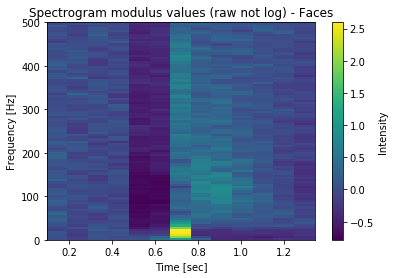

In [16]:
print(f"channel index {channel_idx}")
comb_specgram_channel_ch_10 = zscore_specgram_wrapper(arr_all_trials=all_pat_chn_trials[channel_idx], pre_col_range=range(4), pst_col_range=range(4, 14), 
                            fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                            trials_samp_idx=None, filter_row_idx=None, log_Sxx=False)
#print(comb_specgram_channel_ch_10.shape)

# Plot the spectrogram
plt.pcolormesh(t, f, comb_specgram_channel_ch_10)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

## Let's look at the same PSD but restrict to first 100Hz

In [19]:
t
f

array([  0.        ,   5.20833333,  10.41666667,  15.625     ,
        20.83333333,  26.04166667,  31.25      ,  36.45833333,
        41.66666667,  46.875     ,  52.08333333,  57.29166667,
        62.5       ,  67.70833333,  72.91666667,  78.125     ,
        83.33333333,  88.54166667,  93.75      ,  98.95833333,
       104.16666667, 109.375     , 114.58333333, 119.79166667,
       125.        , 130.20833333, 135.41666667, 140.625     ,
       145.83333333, 151.04166667, 156.25      , 161.45833333,
       166.66666667, 171.875     , 177.08333333, 182.29166667,
       187.5       , 192.70833333, 197.91666667, 203.125     ,
       208.33333333, 213.54166667, 218.75      , 223.95833333,
       229.16666667, 234.375     , 239.58333333, 244.79166667,
       250.        , 255.20833333, 260.41666667, 265.625     ,
       270.83333333, 276.04166667, 281.25      , 286.45833333,
       291.66666667, 296.875     , 302.08333333, 307.29166667,
       312.5       , 317.70833333, 322.91666667, 328.12

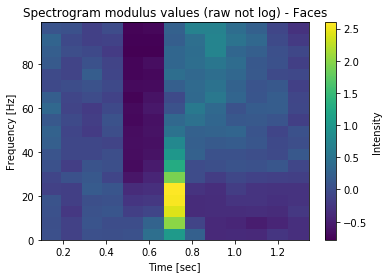

In [17]:
# Plot the spectrogram
plt.pcolormesh(t, f[range(20)], comb_specgram_channel_ch_10[range(20), :])
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

This appears to only loosely match with Yuanning's power spectrum density plot for **P41, Session 1, Faces**. We are not seeing a bright hotspot in the top right hand side i.e. in 800-1000ms range

Method to curb this issue is as follows:
- in `Matlab` produce the spectrogram with the same parameters as used above
- Confirm the output for a single trial i.e. check frequency bands and also the 
- Do the same z-scoring, up to first 500ms, and thereafter - check that we match the bands correctly!
- Ensure that z-scoring for pre-stim is done without removing any milliseconds, and same for post-stim

## Let's do this on the log-scale (note this means we log-scale the spectrograms BEFORE calculating z-scores)

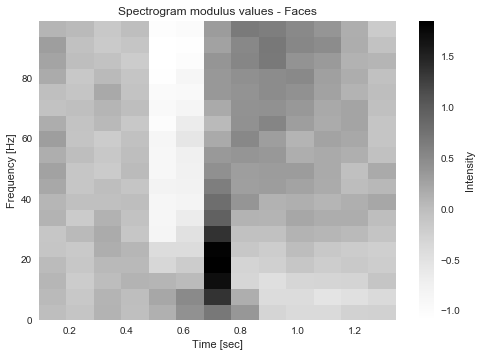

In [77]:
comb_specgram_channel_ch_10_log = zscore_specgram_wrapper(arr_all_trials=all_pat_chn_trials[channel_idx], pre_col_range=range(4), pst_col_range=range(4, 14), 
                            fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                            trials_samp_idx=None, filter_row_idx=None, log_Sxx=True) # LOG-SCALE
#print(comb_specgram_channel_ch_10.shape)

# Plot the spectrogram
plt.pcolormesh(t, f[range(20)], comb_specgram_channel_ch_10_log[range(20), :])
plt.title(f"Spectrogram modulus values - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

Funnily this seems to match Yuanning's wavelet basis results better i.e. is "smoother" even though I confirmed with Yuanning that he used **linear scale**

## Just for interest: Do the same analysis for a single trial i.e. trial 5 for all channels of P41, Faces, Session 1

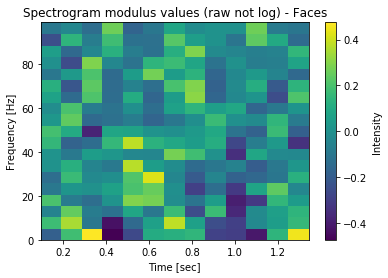

In [24]:
trial_05_comb_specgram = zscore_specgram_wrapper(arr_all_trials=pat_trial_5_all_chn, pre_col_range=range(4), pst_col_range=range(4, 14), 
                                                 fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                                 trials_samp_idx=None, filter_row_idx=None, log_Sxx=False)
pat_trial_5_all_chn.shape
plt.pcolormesh(t, f[range(20)], trial_05_comb_specgram[range(20), :])
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

# 85 Channels - P41, Faces, Session 1

### Perform NMF for P41 - 85 Channels, Faces, Session 1 - DENORMALIZED TRIALS, IS DIVERGENCE NMF
#### (100% sampling of trials, 100% sampling of time)

In [25]:
np.random.seed(seed=103224)

In [27]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = list(range(85))
trials_type = "category"
ord = None # No normalization trials
samp_trial_pop = 1.0 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
session_idx = 1
core_cat = "Faces"
filter_row_idx=range(21)
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx = False
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

In [28]:
V, W, H = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop,
                                      time_samp_prop=time_samp_prop,
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, 
                                      solver=solver,
                                      max_iter=max_iter)

84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!


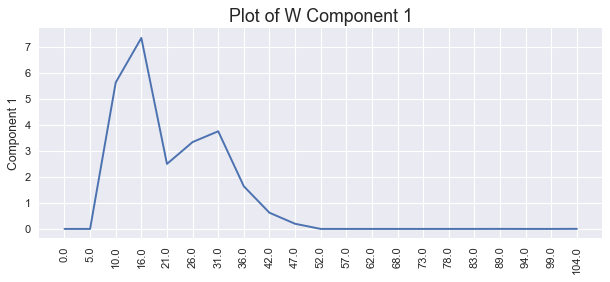

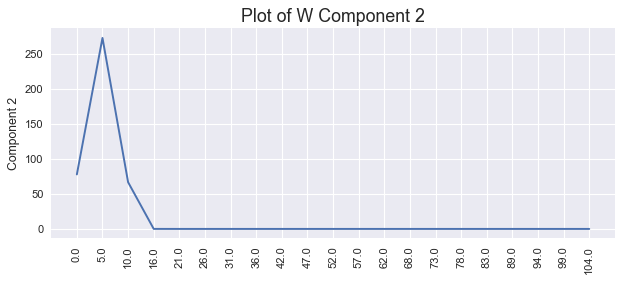

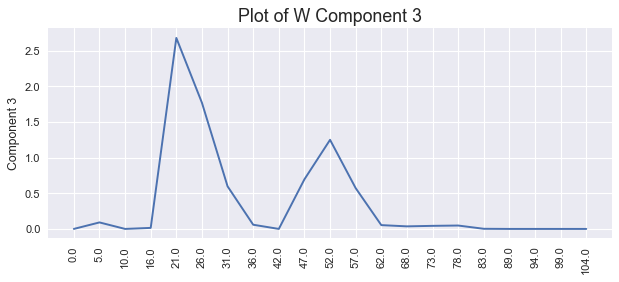

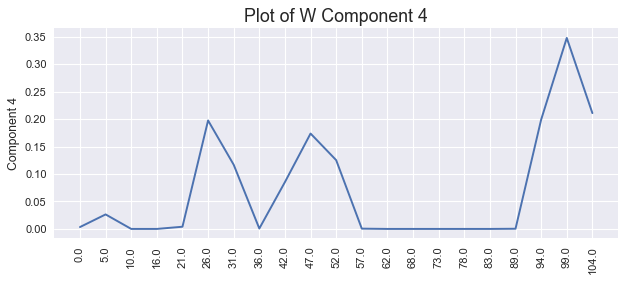

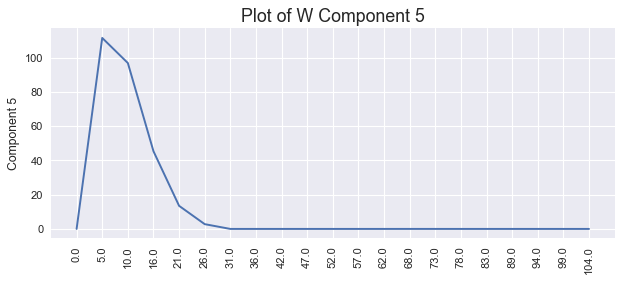

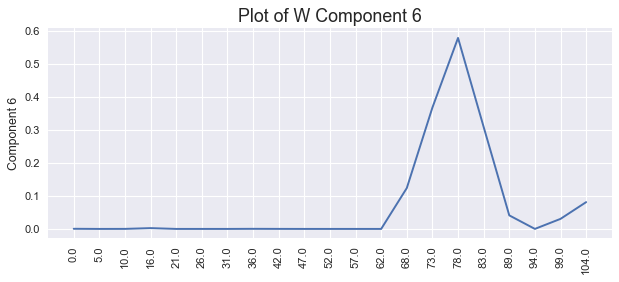

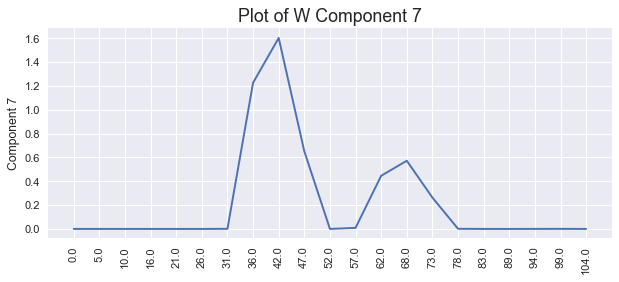

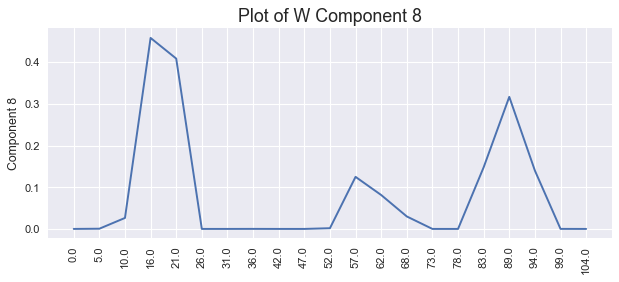

In [29]:
#freq_ticks = np.around(np.linspace(0, 100, num=len(filter_row_idx)), decimals=0)
freq_ticks = f[filter_row_idx]
#freq_ticks
plotW(W = W, log=False, x_ticks_l=freq_ticks)

99960


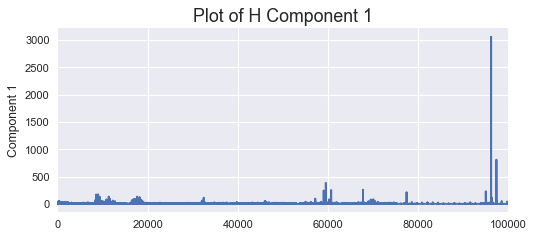

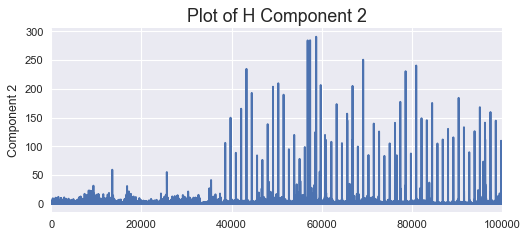

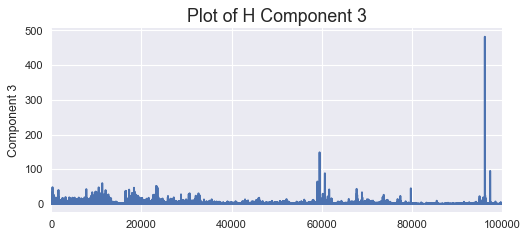

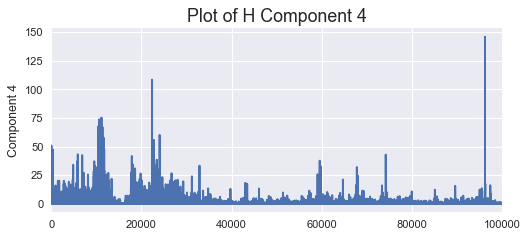

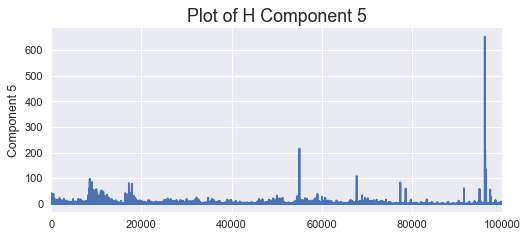

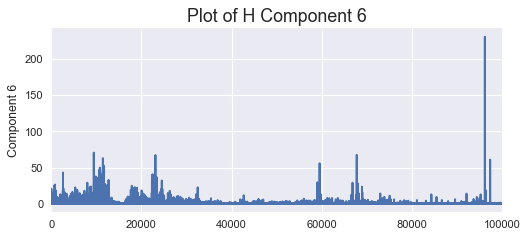

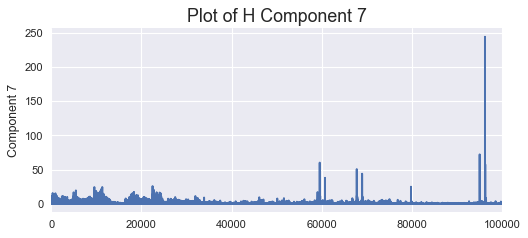

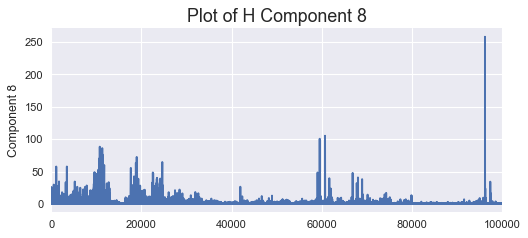

In [30]:
plotH(H = H, log=False, y_ticks_l=None)

## REPEAT: L2-norm for TRIALS, IS-norm NMF

In [31]:
ord1 = 2 # L2-norm

V1, W1, H1 = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord1, # L2-norm
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop,
                                      time_samp_prop=time_samp_prop,
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, # I-S loss NMF
                                      solver=solver,
                                      max_iter=max_iter)
print(ord1)
print(beta_loss)

we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
2
itakura-saito


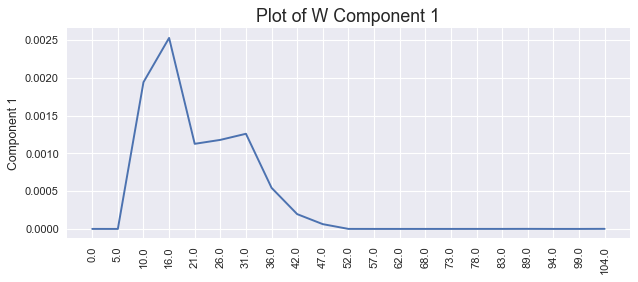

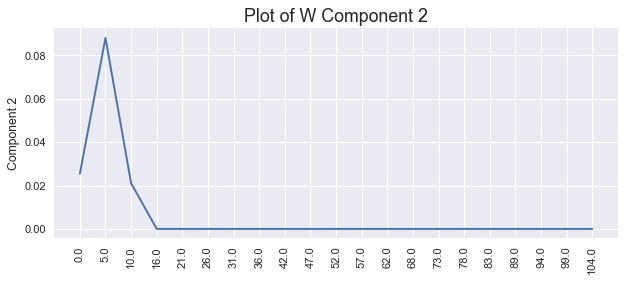

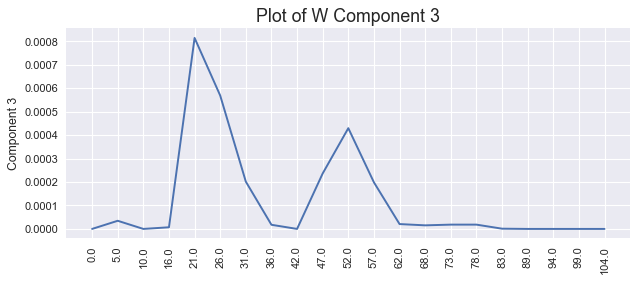

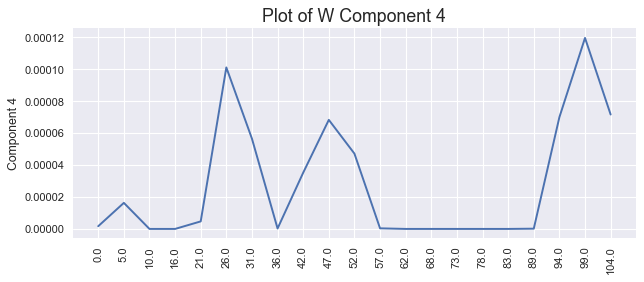

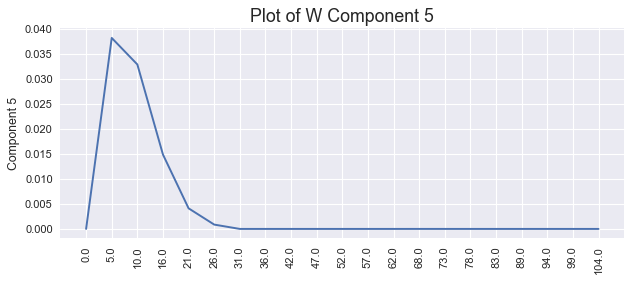

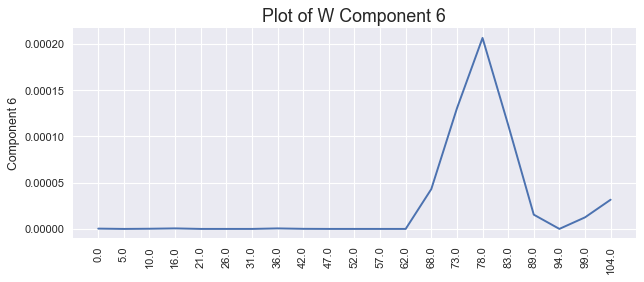

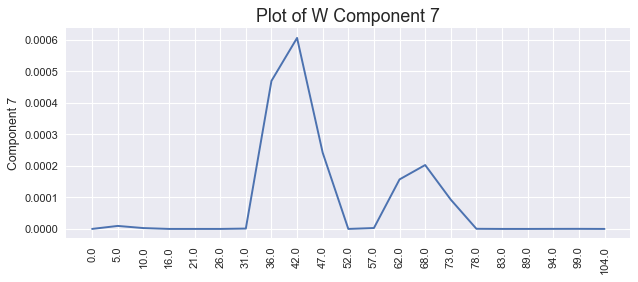

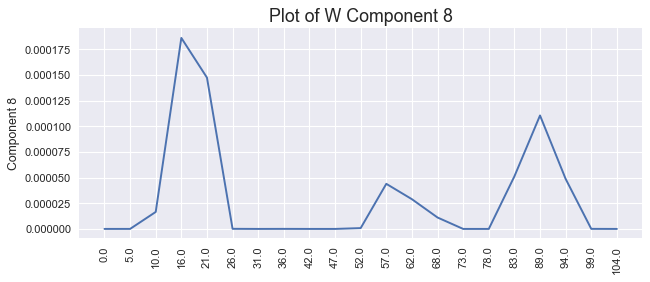

In [32]:
#freq_ticks
plotW(W = W1, log=False, x_ticks_l=freq_ticks)

99960


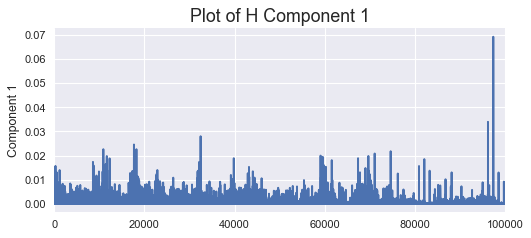

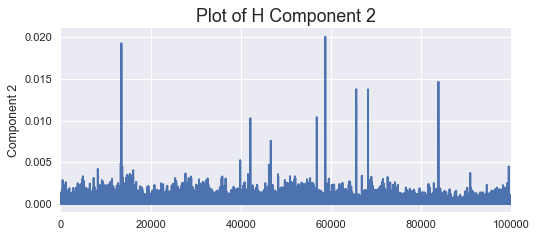

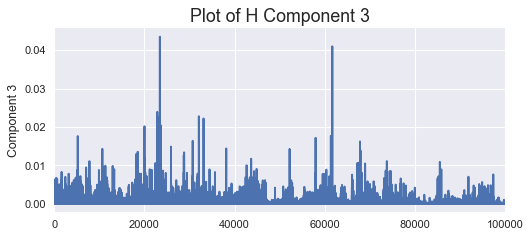

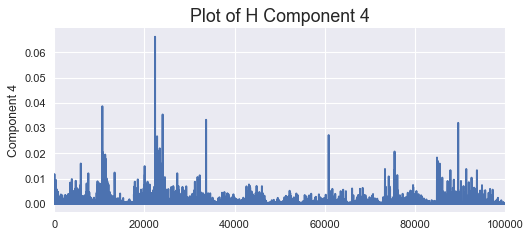

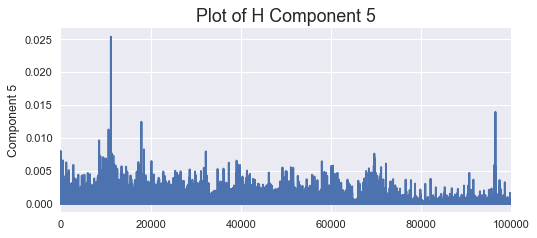

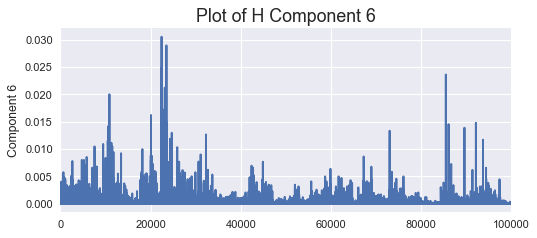

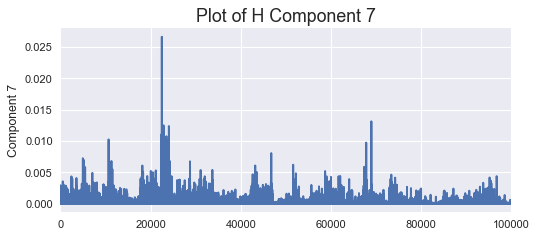

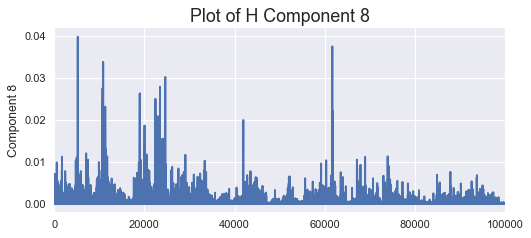

In [33]:
plotH(H = H1, log=False, y_ticks_l=None)

## REPEAT: L1-norm for TRIALS, IS-norm NMF

In [34]:
ord2 = 1 # L1-norm

V2, W2, H2 = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord2, # L2-norm
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop,
                                      time_samp_prop=time_samp_prop,
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, # I-S loss NMF
                                      solver=solver,
                                      max_iter=max_iter)

print(ord2)
print(beta_loss)

we are using the 1-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
1
itakura-saito


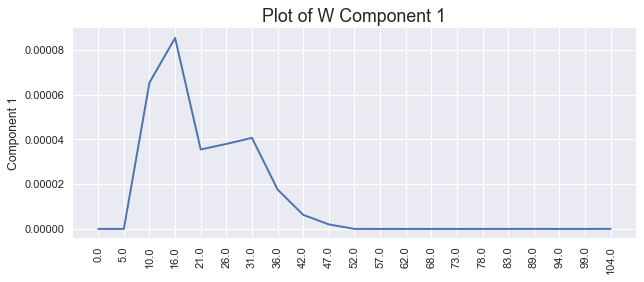

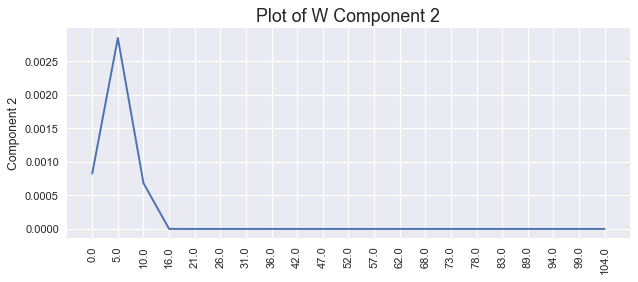

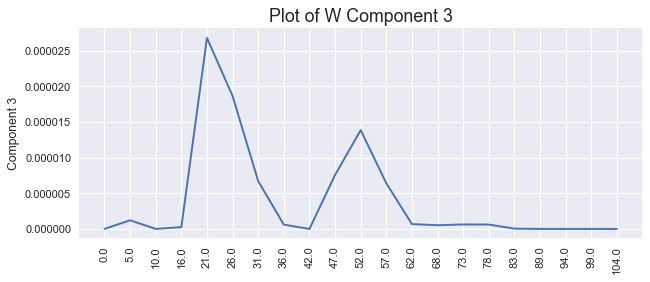

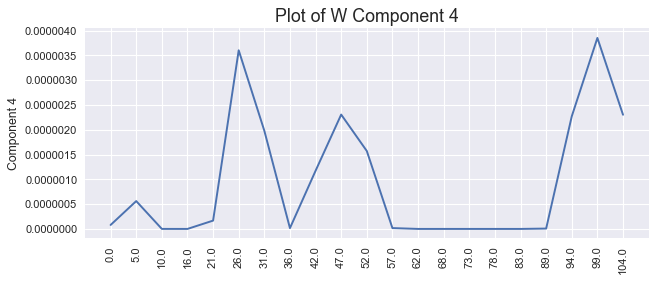

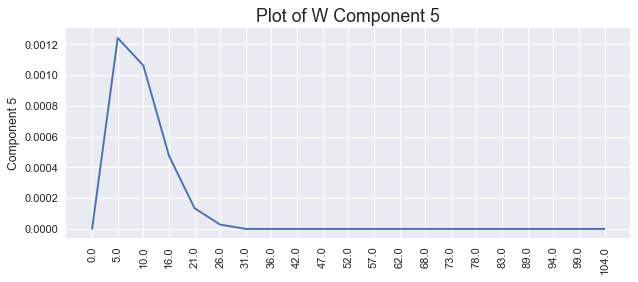

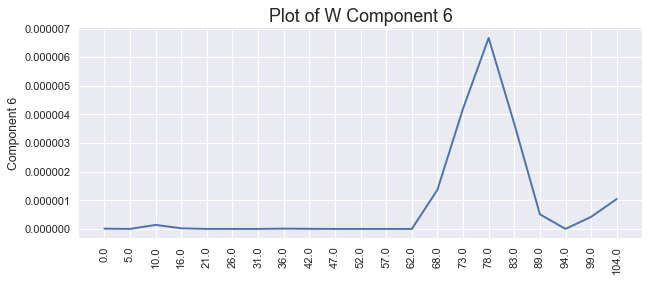

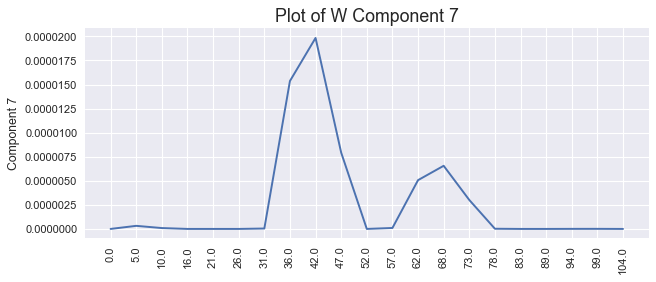

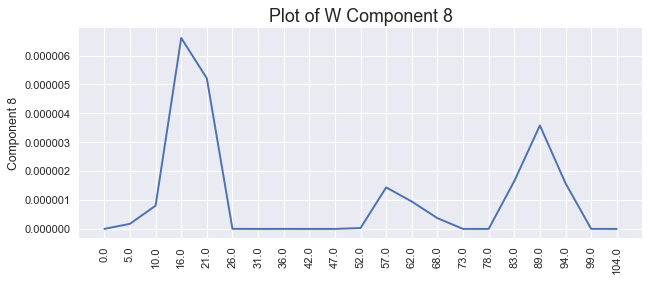

In [35]:
#freq_ticks
plotW(W = W2, log=False, x_ticks_l=freq_ticks)

99960


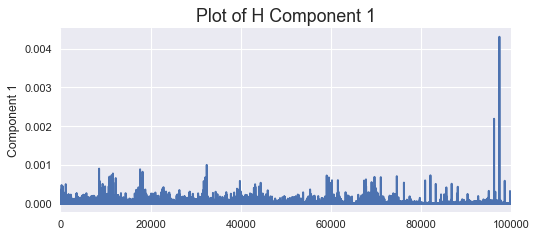

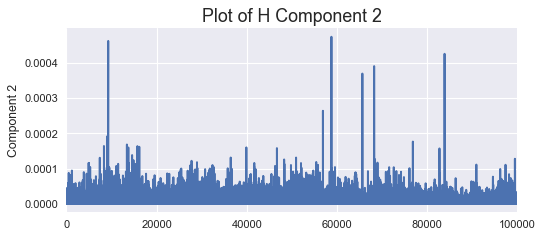

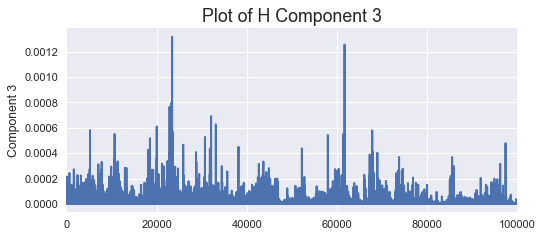

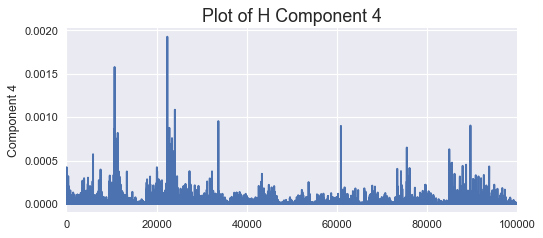

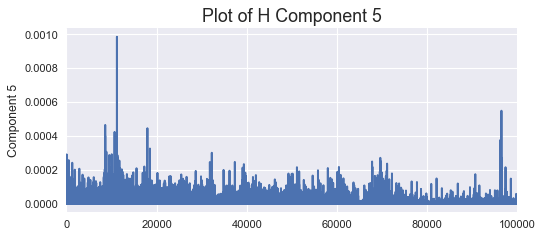

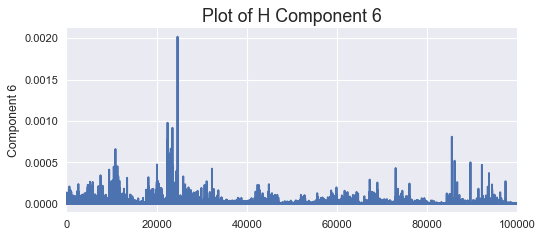

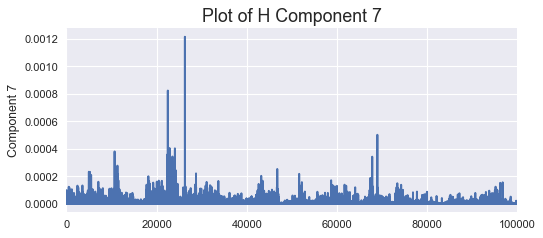

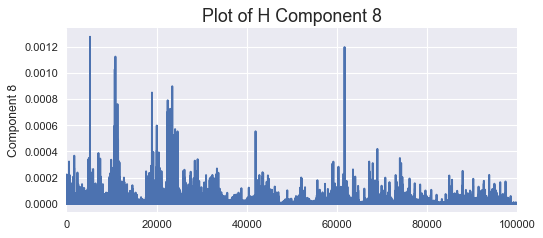

In [36]:
plotH(H = H2, log=False, y_ticks_l=None)

## REPEAT: L2-norm for TRIALS, FROBENIUS norm NMF

In [61]:
ord3 = 2 # L1-norm
beta_loss2 = "frobenius"

V3, W3, H3 = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord3, # L2-norm
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop,
                                      time_samp_prop=time_samp_prop,
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss2, # FROBENIUS loss NMF
                                      solver=solver,
                                      max_iter=max_iter)

print(ord3)
print(beta_loss2)

we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
2
frobenius


/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


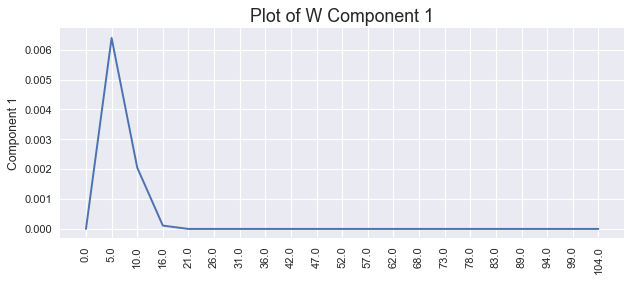

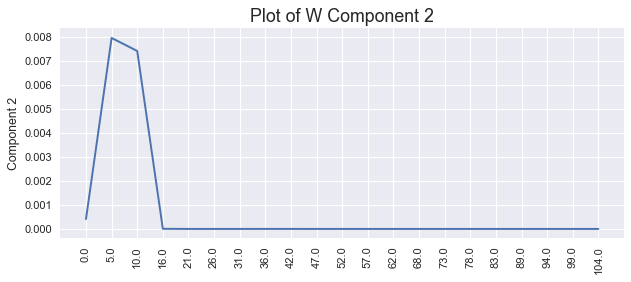

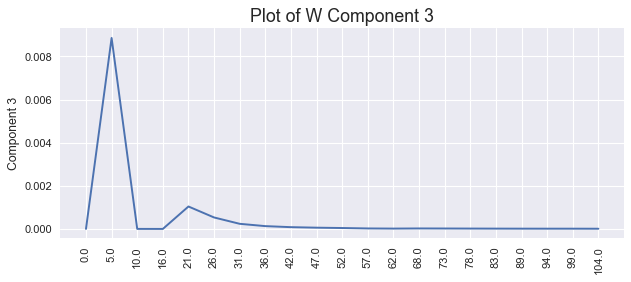

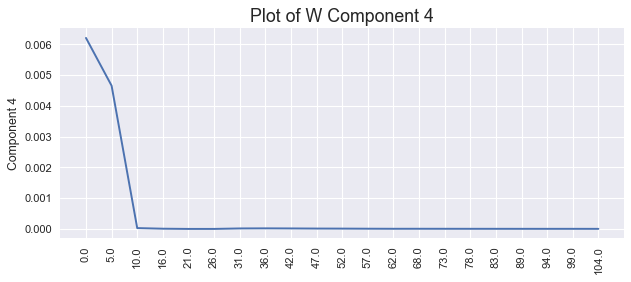

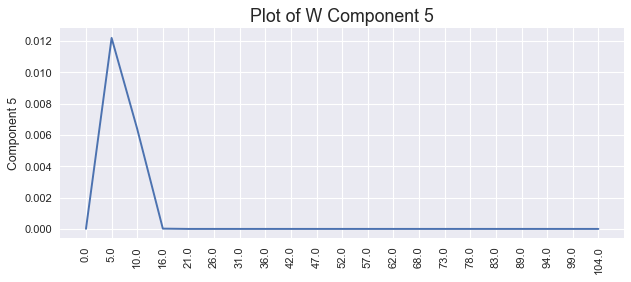

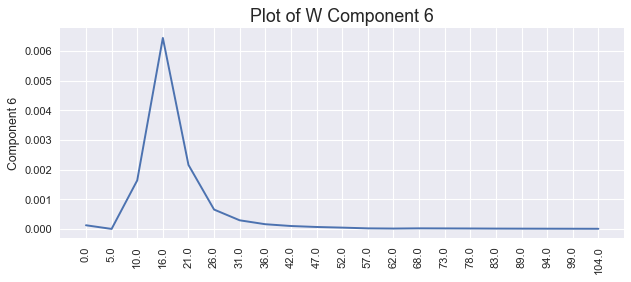

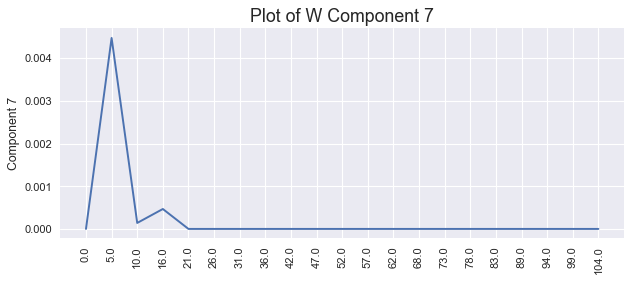

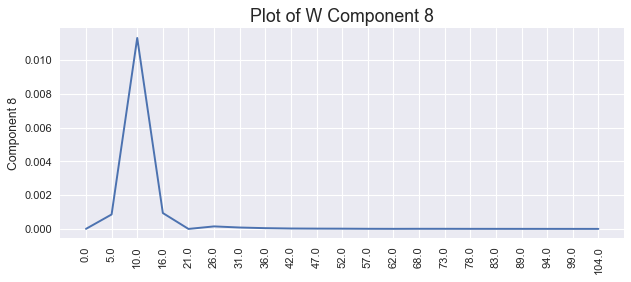

In [62]:
plotW(W = W3, log=False, x_ticks_l=freq_ticks)

99960


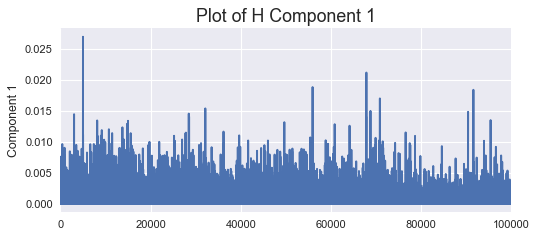

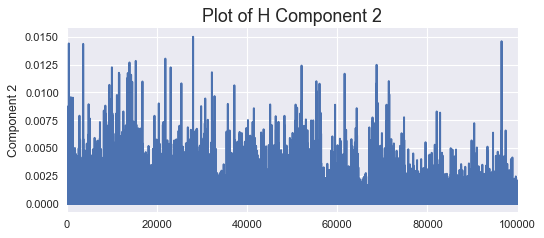

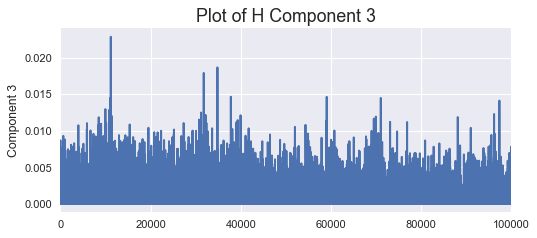

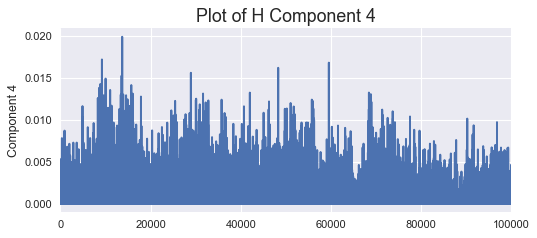

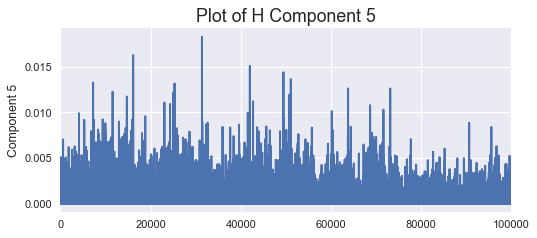

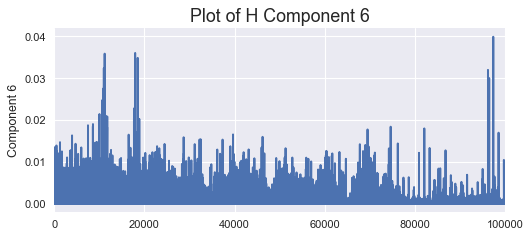

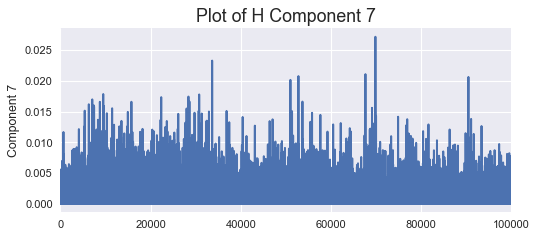

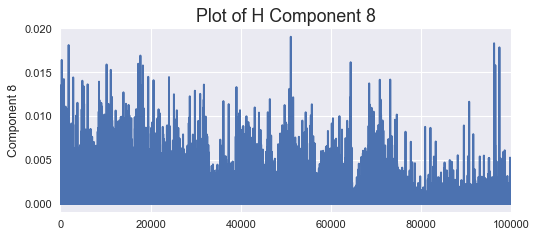

In [63]:
plotH(H = H3, log=False, y_ticks_l=None)

## Check the absolute deviation difference

In [64]:
def H_comp_deviation(H, comp_idx):
    return np.max(H[comp_idx])/np.median(H[comp_idx])

In [69]:
H_comp_idx = 4
print(f"The Median deviation of the max-value-to the median is UNNORMALIZED trials and IS-NMF {H_comp_deviation(H = H, comp_idx = H_comp_idx)}")
print(f"The Median deviation of the max-value-to the median is L2 NORMALIZED trials and IS-NMF {H_comp_deviation(H = H1, comp_idx = H_comp_idx)}")
print(f"The Median deviation of the max-value-to the median is L1 NORMALIZED trials and IS-NMF {H_comp_deviation(H = H2, comp_idx = H_comp_idx)}")
print(f"The Median deviation of the max-value-to the median is L2 NORMALIZED trials and FROBENIUS {H_comp_deviation(H = H3, comp_idx = H_comp_idx)}")

The Median deviation of the max-value-to the median is UNNORMALIZED trials and IS-NMF 2166.639418420663
The Median deviation of the max-value-to the median is L2 NORMALIZED trials and IS-NMF 258.2954579828174
The Median deviation of the max-value-to the median is L1 NORMALIZED trials and IS-NMF 223.45604554639877
The Median deviation of the max-value-to the median is L2 NORMALIZED trials and FROBENIUS 203.43869593480693


# Bootstrap Analysis - repeat trials and see stability of the $W$ matrix

In [78]:
print(beta_loss)

itakura-saito


In [70]:
num_reps = 20
samp_trial_pop1 = 0.7
time_samp_prop1 = 0.5
results_NMF = [entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord1, # L2-norm
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop1, # 70% of trials
                                      time_samp_prop=time_samp_prop1, # 50% of time
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, # I-S loss NMF
                                      solver=solver,
                                      max_iter=max_iter) for i in range(num_reps)]

we are using the 2-norm to normalize trials
58
comb_all_channels_specgrams: (21, 69020)
time_samp_idx length: 34510
comb_specgram_time_sample: (21, 34510)
STARTING NMF...
V: (21, 34510)
W: (21, 8)
H: (8, 34510)
NMF COMPLETE!
we are using the 2-norm to normalize trials
58
comb_all_channels_specgrams: (21, 69020)
time_samp_idx length: 34510
comb_specgram_time_sample: (21, 34510)
STARTING NMF...
V: (21, 34510)
W: (21, 8)
H: (8, 34510)
NMF COMPLETE!
we are using the 2-norm to normalize trials
58
comb_all_channels_specgrams: (21, 69020)
time_samp_idx length: 34510
comb_specgram_time_sample: (21, 34510)
STARTING NMF...
V: (21, 34510)
W: (21, 8)
H: (8, 34510)
NMF COMPLETE!
we are using the 2-norm to normalize trials
58
comb_all_channels_specgrams: (21, 69020)
time_samp_idx length: 34510
comb_specgram_time_sample: (21, 34510)
STARTING NMF...
V: (21, 34510)
W: (21, 8)
H: (8, 34510)
NMF COMPLETE!
we are using the 2-norm to normalize trials
58
comb_all_channels_specgrams: (21, 69020)
time_samp_id

### Create the tensor of all the $W$ matrices

In [72]:
W_mats = [results_NMF[i][1] for i in range(len(results_NMF))]
W_tens = np.dstack(tup=W_mats)
W_tens.shape
W_tens[:, 0, :].shape
len(W_mats)
#W_mats[9].shape

20

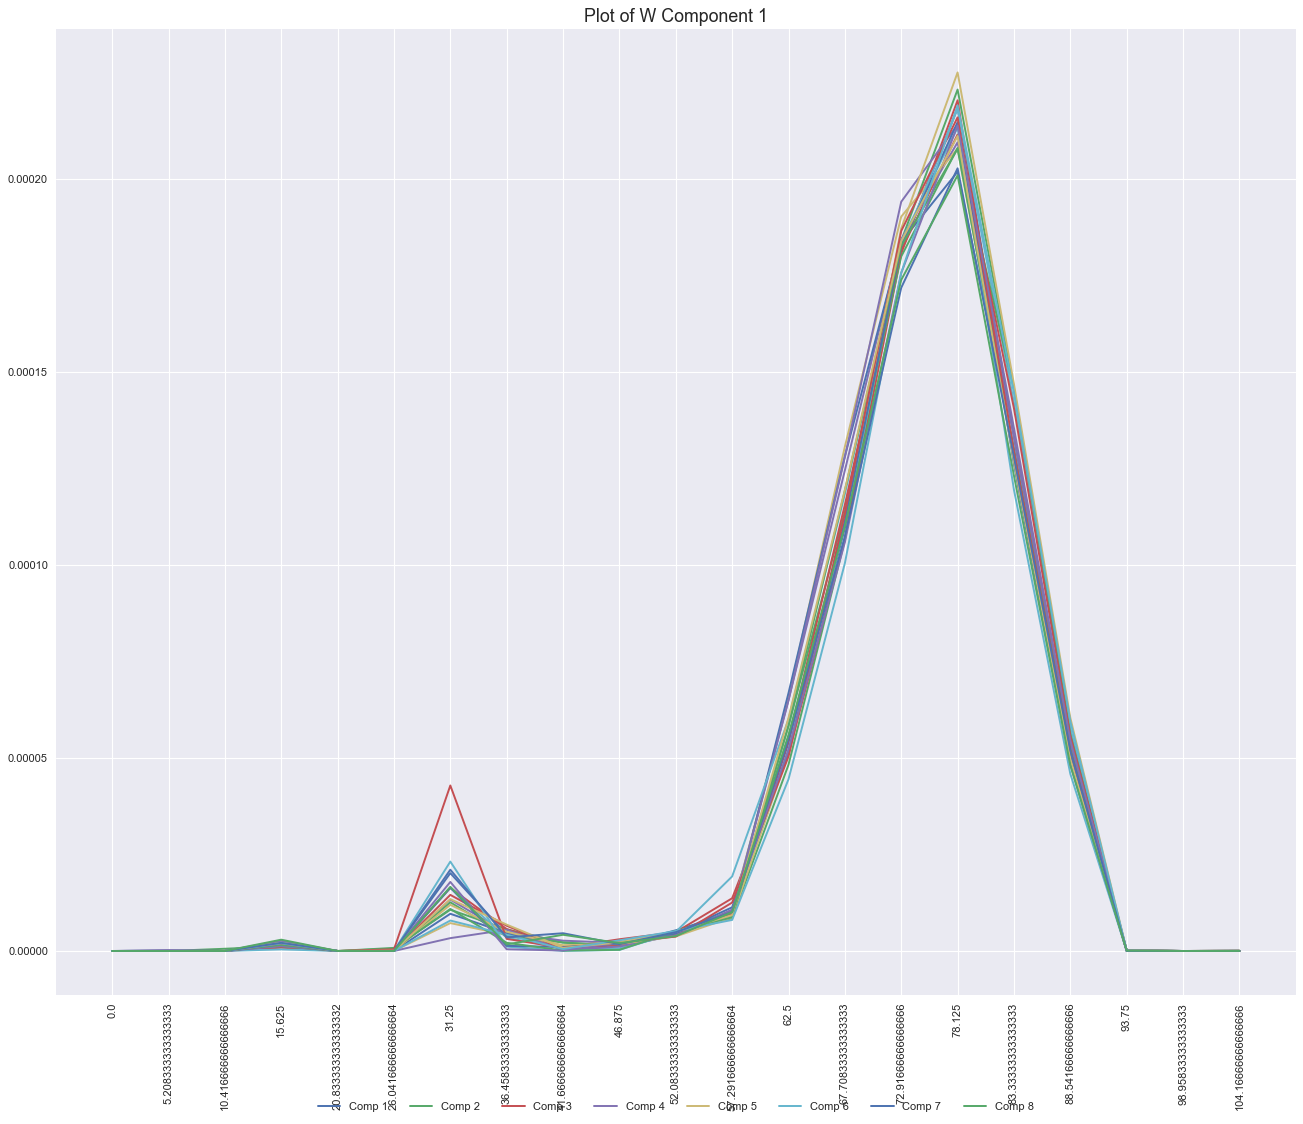

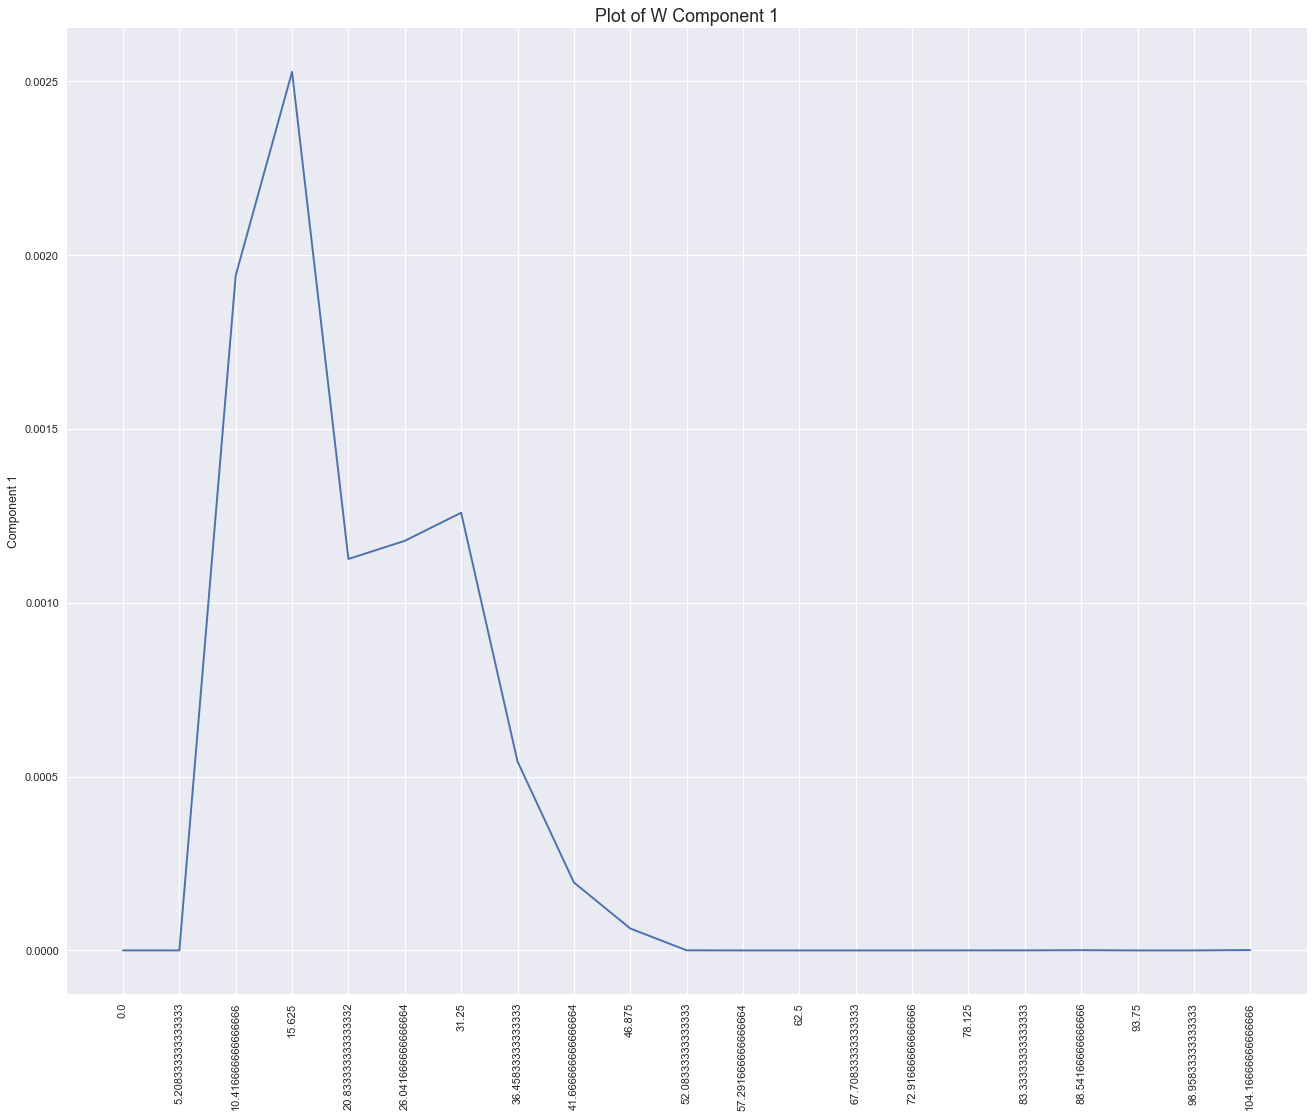

In [73]:
def repl_check_W(W_tens, W_all_trials, component, x_ticks_l):
    plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
    num_replicates = W_tens.shape[1]
    plt.title(f'Plot of W Component {component + 1}', fontsize=16)    
    legend_names = [f'Comp {n + 1}' for n in range(num_replicates)]    
    plt.plot(W_tens[:, component, :])
    plt.xticks(range(0, W_all_trials.shape[0]), x_ticks_l, rotation='vertical')
    plt.legend(legend_names, loc=9, bbox_to_anchor=(0.5, -0.1), ncol = 10)
    plt.show()   
    
    plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(W_all_trials[:, component])
    plt.title(f'Plot of W Component {component + 1}', fontsize=16)    
    plt.xticks(range(0, W_all_trials.shape[0]), x_ticks_l, rotation='vertical')
    plt.ylabel(f'Component {component + 1}')
    plt.show()

repl_check_W(W_tens=W_tens, W_all_trials=W1, component=0, x_ticks_l=freq_ticks)

### Replicate NMF 20 times 
#### (100% sampling of trials, 20% sampling of time)

In [74]:
num_reps = 20
samp_trial_pop2 = 1.0
time_samp_prop2 = 1.0
results_NMF1 = [entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord1, # L2-norm
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop2, # 100% of trials
                                      time_samp_prop=time_samp_prop2, # 100% of time
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, # I-S loss NMF
                                      solver=solver,
                                      max_iter=max_iter) for i in range(num_reps)]

we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!
we are using the 2-norm to normalize trials
84
comb_all_channels_specgrams: (21, 99960)
time_samp_id

In [75]:
#results_NMF1 = results_NMF
W_mats1 = [results_NMF1[i][1] for i in range(len(results_NMF1))]
W_tens1 = np.dstack(tup=W_mats1)
W_tens1.shape
W_tens1[:, 0, :].shape
#len(W_mats)
#W_mats[9].shape

(21, 20)

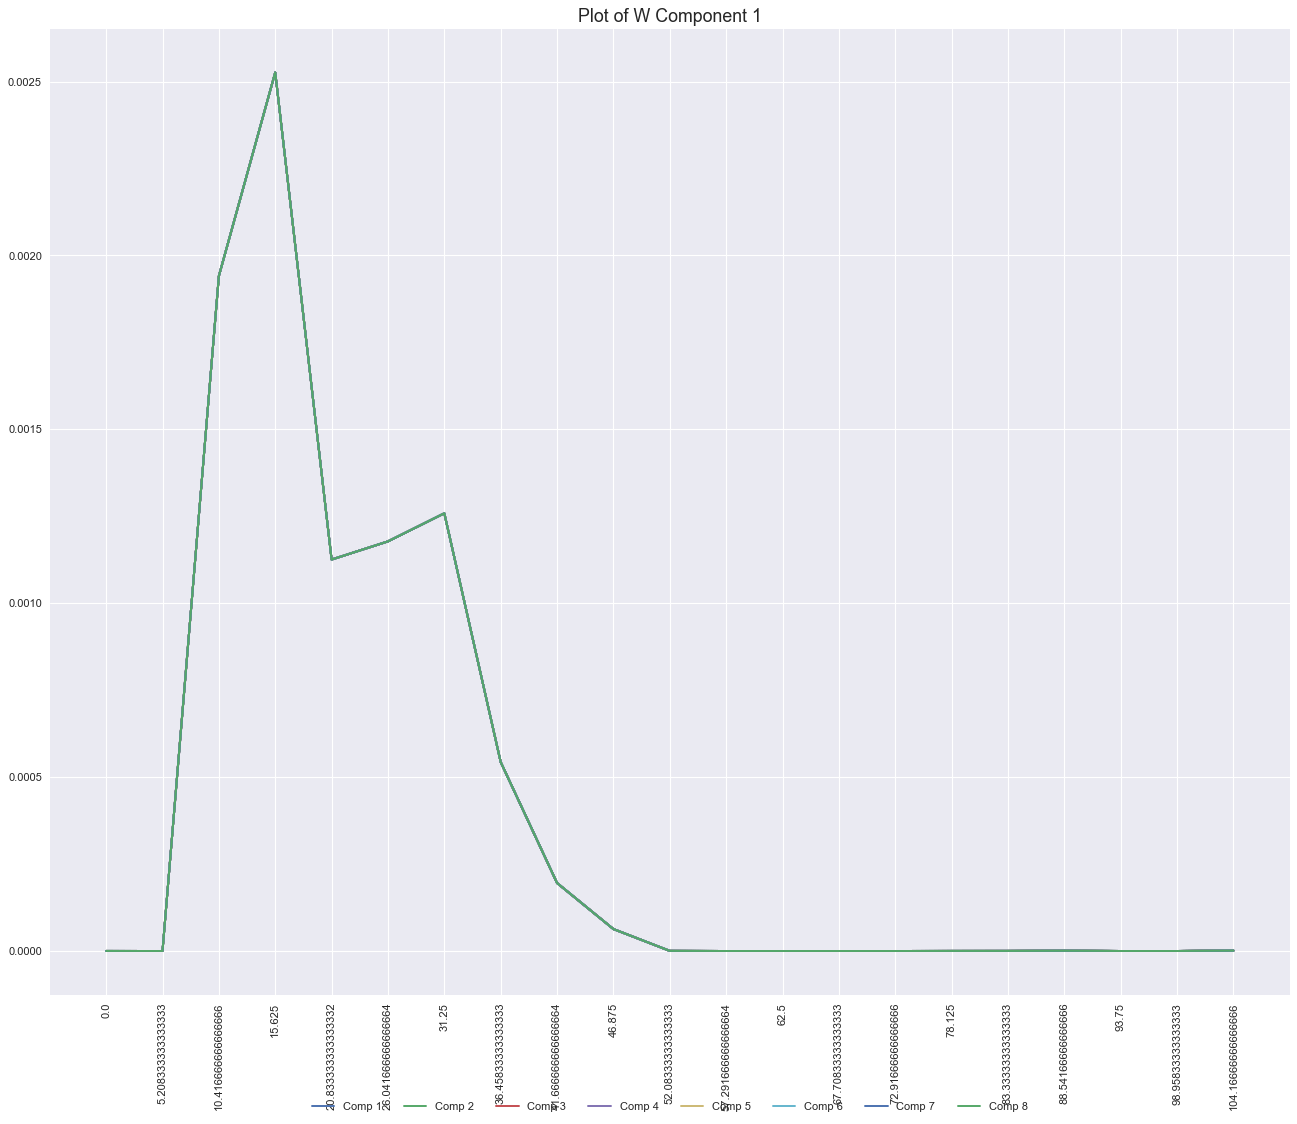

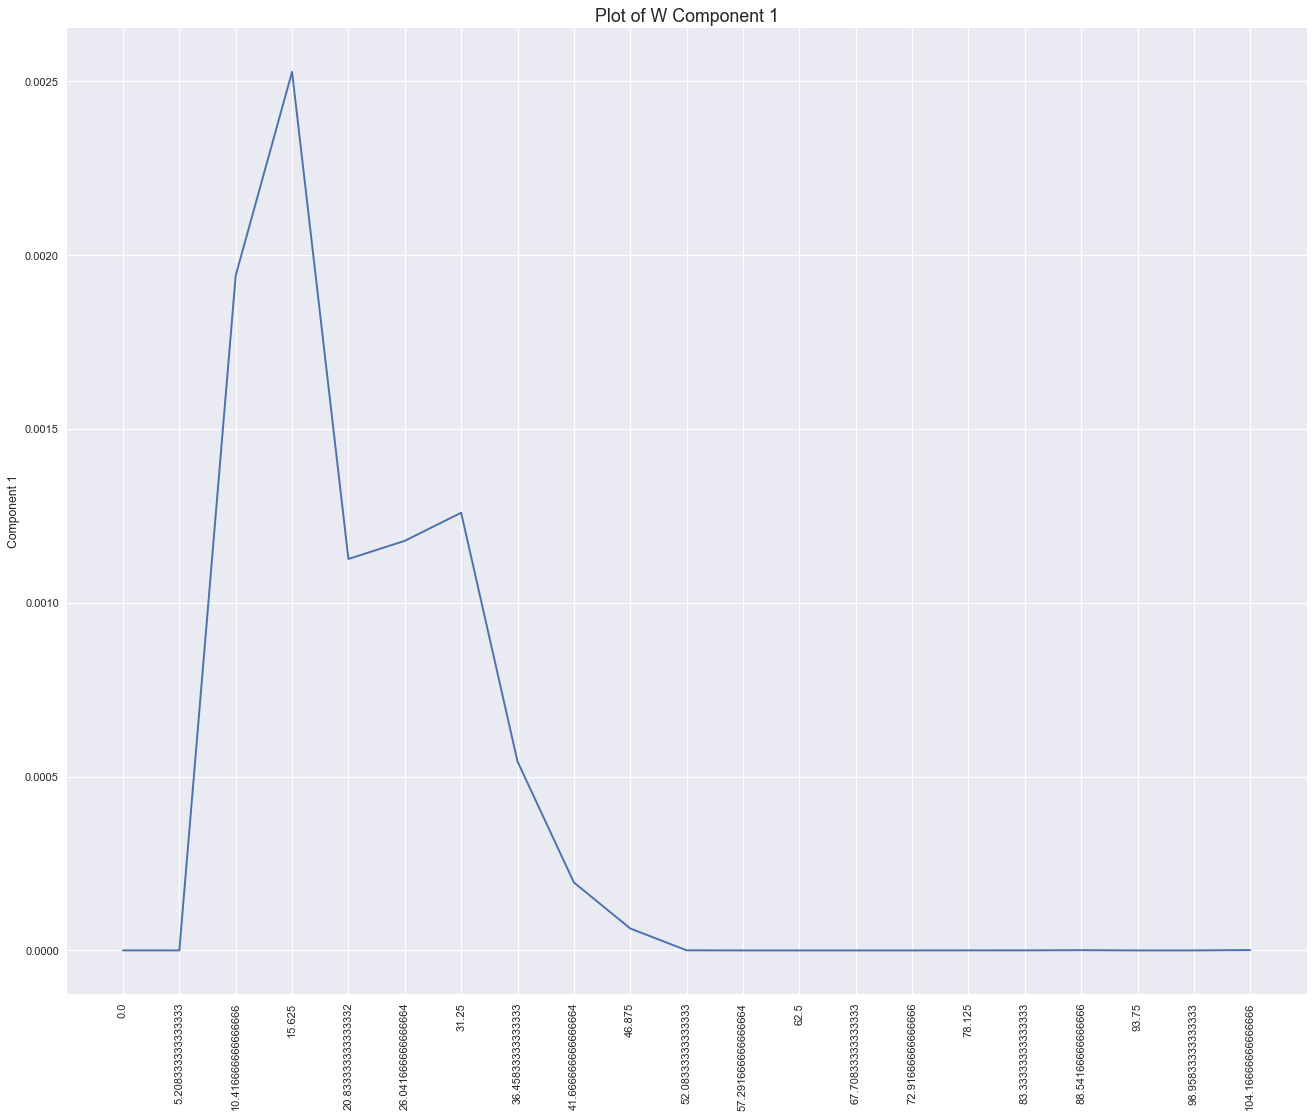

In [76]:
repl_check_W(W_tens=W_tens1, W_all_trials=W1, component=0, x_ticks_l=freq_ticks)

## New tasks - for Discussion
- How many frequency bands to choose? Is 8 reasonable, can we select these in a more principled way?
- What are the highest observed frequencies in the brain at which something interesting is observed to occur?
- Check stability when trials are sampled and how to deal with this?
- Combine sessions for a single patient
- Combine patients at some point?
- Consider the time lag in the ERP signal?
- AG: Taper - wavelet basis. Different frequencies
- AG: Sample equally in frequencies and time